# 579 - A3

In [7]:
import pandas
import numpy as np
import gymnasium as gym
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## Data Preprocessing

In [8]:
def load_data(file_path):
    data = pandas.read_csv(file_path, index_col=False)
    return data

np.set_printoptions(edgeitems=30)
# expert_100 = np.genfromtxt('expert_100.csv', delimiter=',')[1:-1]
# expert_100_im = load_data('expert_100.csv')


## Data Discretization and One-Hot Encode

dimension of state: num_data by 40

In [9]:
def one_hot(s1, s2, s3, s4):
    a = np.array([s1, s2, s3, s4])
    b = np.zeros((a.size, 10))
    b[np.arange(a.size), a] = 1
    return b.reshape(-1)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def getBin(s, intervals):
    for i in range(len(intervals)):
        if intervals[i].left <= s <= intervals[i].right:
            return i
    return 0

## Simple Imitation

In [10]:
def simple_imitation(data):
    data_ac = data[["state_0", "state_1", "state_2", "state_3"]]
    action_data_ac = data[["action_count"]]

    X = data_ac
    y = action_data_ac
    clf = LogisticRegression(random_state=1).fit(X.values, y.values.reshape(len(y),))

    env = gym.make("CartPole-v1")
    rewards = []
    for episode in range(100):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            #print(state)
            action = clf.predict([state])
            next_state, reward, done, _, _ = env.step(action[0])
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

## Fitted_Q Learning

In [11]:
def update(state, action, reward, next_state, weights, lr):
    pred_next = next_state.dot(weights) # evaluating Q, (n x 40) dot (40 x 2) gives (n x 2)
    max_v = np.max(pred_next) # n x 1 where each entry is max Q value of that row
    y = reward + 0.99*max_v # n x 1
    temp = state.dot(weights) # n x 2
    q = np.array([temp[i][action[i]] for i in range(len(action))]) # n x 1
    gradient = np.reshape(q-y, (len(state), 1))*state
    for i in range(len(state)):
        weights[:,action[i]] -= lr*gradient[i]

def fitted_q(data, do_sigmoid = True):
    actions = np.array(data[:,4]).astype(int)
    rewards = data[:,9]

    #do_sigmoid = True
    if (do_sigmoid):
        data[:,0] = np.vectorize(sigmoid)(data[:,0])
        data[:,1] = np.vectorize(sigmoid)(data[:,1])
        data[:,2] = np.vectorize(sigmoid)(data[:,2])
        data[:,3] = np.vectorize(sigmoid)(data[:,3])

        data[:,5] = np.vectorize(sigmoid)(data[:,5])
        data[:,6] = np.vectorize(sigmoid)(data[:,6])
        data[:,7] = np.vectorize(sigmoid)(data[:,7])
        data[:,8] = np.vectorize(sigmoid)(data[:,8])

    s1 = pandas.qcut(data[:,0], 10, labels=range(0,10))
    s2 = pandas.qcut(data[:,1], 10, labels=range(0,10))
    s3 = pandas.qcut(data[:,2], 10, labels=range(0,10))
    s4 = pandas.qcut(data[:,3], 10, labels=range(0,10))
    states_onehot = np.array([one_hot(s1[i], s2[i], s3[i], s4[i]) for i in range(len(s1))]) # rows x

    s1_cat = pandas.qcut(data[:,0], 10)
    s2_cat = pandas.qcut(data[:,1], 10)
    s3_cat = pandas.qcut(data[:,2], 10)
    s4_cat = pandas.qcut(data[:,3], 10)

    nx1 = pandas.qcut(data[:,5], 10, labels=range(0,10))
    nx2 = pandas.qcut(data[:,6], 10, labels=range(0,10))
    nx3 = pandas.qcut(data[:,7], 10, labels=range(0,10))
    nx4 = pandas.qcut(data[:,8], 10, labels=range(0,10))
    nextstates_onehot = np.array([one_hot(nx1[i], nx2[i], nx3[i], nx4[i]) for i in range(len(s1))])

    weights = np.random.uniform(-0.001, 0.001, (40,2))

    k = 5
    for i in range(k):
        update(states_onehot, actions, rewards, nextstates_onehot, weights, 0.00001)

    env = gym.make("CartPole-v1")
    rewards = []
    for episode in range(100):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            if (do_sigmoid):
                state = np.vectorize(sigmoid)(state)
            b1 = getBin(state[0], s1_cat.categories)
            b2 = getBin(state[1], s2_cat.categories)
            b3 = getBin(state[2], s3_cat.categories)
            b4 = getBin(state[3], s4_cat.categories)
            state = one_hot(b1,b2,b3,b4)

            action = np.argmax(state.dot(weights))
            next_state, reward, done, _, _ = env.step(action)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
    return np.mean(rewards), np.std(rewards)

## Plotting Results

expert_500 Simple Imitation mean:  222.39
expert_500 Simple Imitation standard_deviation:  61.25730895166714
expert_500 Fitted Q mean: 178.25
expert_500 Fitted Q standard_deviation: 37.910783426355096
expert_250 Simple Imitation mean:  212.86
expert_250 Simple Imitation standard_deviation:  64.94752035297421
expert_250 Fitted Q mean: 164.64
expert_250 Fitted Q standard_deviation: 30.05545541162203
expert_100 Simple Imitation mean:  211.31
expert_100 Simple Imitation standard_deviation:  52.34667038121909
expert_100 Fitted Q mean: 183.09
expert_100 Fitted Q standard_deviation: 52.40154482455646
mixed_500 Simple Imitation mean:  210.71
mixed_500 Simple Imitation standard_deviation:  56.232605310442445
mixed_500 Fitted Q mean: 164.68
mixed_500 Fitted Q standard_deviation: 28.965455287290062
mixed_250 Simple Imitation mean:  199.47
mixed_250 Simple Imitation standard_deviation:  47.93755417206848
mixed_250 Fitted Q mean: 184.12
mixed_250 Fitted Q standard_deviation: 47.44370980435657
mixed

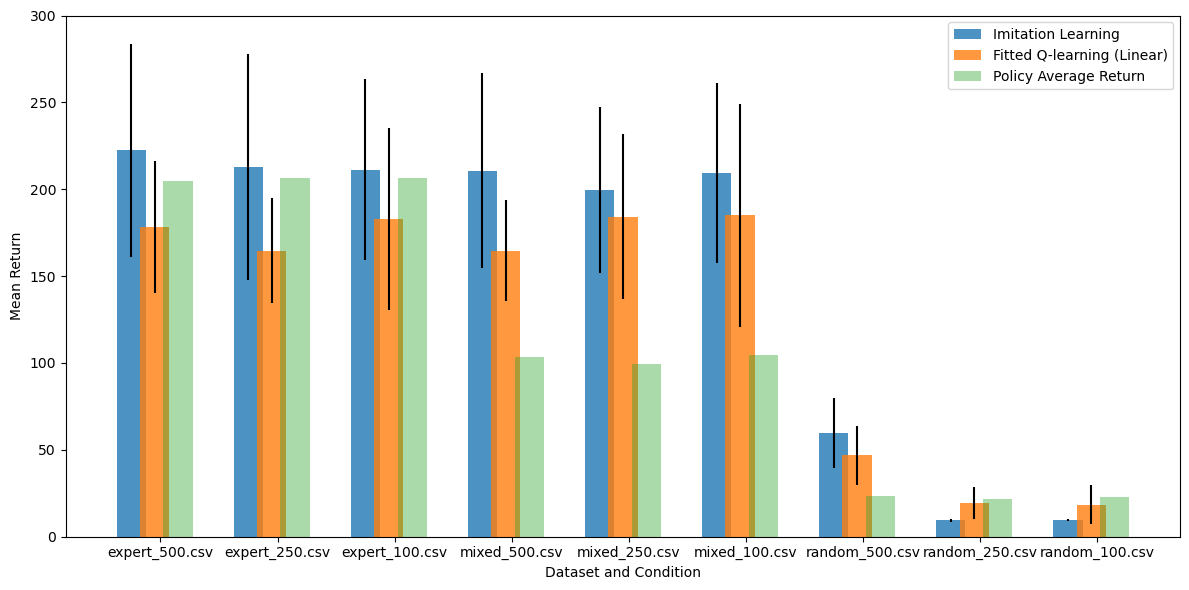

In [12]:
simp_means = []
simp_stdvs = []
fq_means = []
fq_stdvs = []
csvs = ["expert_500.csv", "expert_250.csv","expert_100.csv","mixed_500.csv", "mixed_250.csv","mixed_100.csv", "random_500.csv", "random_250.csv", "random_100.csv"]
original_means = []
for csv in csvs:
    data = np.genfromtxt(csv, delimiter=',')[1:-1]
    data_im = load_data(csv)
    simp_mean, simp_stdv = simple_imitation(data_im)
    simp_means.append(simp_mean)
    simp_stdvs.append(simp_stdv)
    print(f"{csv[:-4]} Simple Imitation mean:  {simp_mean}")
    print(f"{csv[:-4]} Simple Imitation standard_deviation:  {simp_stdv}")
    fq_mean, fq_stdv = fitted_q(data)
    fq_means.append(fq_mean)
    fq_stdvs.append(fq_stdv)
    print(f"{csv[:-4]} Fitted Q mean: {fq_mean}")
    print(f"{csv[:-4]} Fitted Q standard_deviation: {fq_stdv}")
    avg_mean = len(data)/float(csv[-7:-4])
    original_means.append(avg_mean)


# def addlabels(x,y):
#     for i in range(len(x)):
#         plt.text(i,y[i],y[i])

n_datasets = len(csvs)
bar_width = 0.25
opacity = 0.8
plt.figure(figsize = (12,6))
index = np.arange(n_datasets)

plt.bar(index, simp_means, bar_width, alpha=opacity, yerr=simp_stdvs, label="Imitation Learning")
plt.bar(index+0.2, fq_means, bar_width, alpha=opacity, yerr=fq_stdvs,
        label="Fitted Q-learning (Linear)")
plt.bar(index+0.4, original_means, bar_width, alpha=0.4, label="Policy Average Return")
#addlabels(csvs, simp_means)
plt.xlabel("Dataset and Condition")
plt.ylabel("Mean Return")
plt.ylim((0,300))
plt.xticks(index + bar_width,csvs)
plt.legend()
plt.tight_layout()
plt.show()